In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import numpy as np
from autorank import autorank, plot_stats, create_report
from util import  get_all_linear_evaluation_results, clean_linear_probing_results, pivot_linear_probing_results, get_best_performing_per_metric, get_pivot_table_for_q1

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif'],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.title_fontsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "legend.frameon": False,
    "figure.figsize": (9, 3)  # standard size for subplots
})
COLORS = ['#4c90b8', '#2ac3c1', '#f5b811', '#de653e', '#ff912a']
color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}

# 0. Load Results Data

In [6]:
base_results_folder = "results"


In [26]:
final_clustering_df, final_linear_probing_df = get_all_linear_evaluation_results(base_results_folder)
final_clustering_df, final_linear_probing_df = clean_linear_probing_results(final_clustering_df, final_linear_probing_df)

KeyboardInterrupt: 

In [19]:
# Pivot table with baselines

join_keys = ['dataset', 'seed', 'n_labeled', 'metric', 'model']

linear_performance_pivot = pivot_linear_probing_results(final_linear_probing_df, join_keys)

# Average across seeds
average_performance_per_seed = linear_performance_pivot.groupby(['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'metric', 'bracket', 'model'])[['value', 'baseline_none', 'baseline_all', 'baseline_raw_features']].mean().reset_index()

best_performance_per_bracket = get_best_performing_per_metric(average_performance_per_seed,
                                                 aggregation_group=['dataset', 'n_labeled', 'sampling_method', 'n_sample'],
                                                 metric='balanced_accuracy_test')

best_performance_per_nunlabeled_and_bracket = get_best_performing_per_metric(average_performance_per_seed,
                                                 aggregation_group=['dataset', 'n_labeled', 'sampling_method'],
                                                 metric='balanced_accuracy_test')

## 1. Is the embedding space more linearly separable if pretrained on all vs sampled vs none unlabeled examples?

In [20]:
q1_df = best_performance_per_nunlabeled_and_bracket.copy()

# calculate percentages
q1_df['of_baseline_all'] = (q1_df['value'] / q1_df['baseline_all'])*100
q1_df['of_baseline_none'] = (q1_df['value'] / q1_df['baseline_none'])*100
q1_df['of_baseline_raw'] = (q1_df['value'] / q1_df['baseline_raw_features'])*100
q1_df['none_of_all'] = (q1_df['baseline_none'] / q1_df['baseline_all'])*100

In [21]:
value_columns = ['of_baseline_all', 'of_baseline_none', 'none_of_all', 'of_baseline_raw']
q1_answer = get_pivot_table_for_q1(q1_df, value_columns, aggregation='mean')
q1_answer

% Of Baseline All % Of Baseline None  \
n_labeled sampling_method                                                 
50        DisagreementSampling(DS)               104                105   
          DisagreementSampling(DT)               104                105   
          RandomSampling                         102                103   
100       DisagreementSampling(DS)               102                104   
          DisagreementSampling(DT)               102                105   
          RandomSampling                         101                103   
150       DisagreementSampling(DS)               103                104   
          DisagreementSampling(DT)               103                104   
          RandomSampling                         101                102   
200       DisagreementSampling(DS)               100                102   
          DisagreementSampling(DT)               100                102   
          RandomSampling                          99                101   
350       DisagreementSampling(DS)               101                102   
          DisagreementSampling(DT)               101                102   
          RandomSampling                         100                101   
500       DisagreementSampling(DS)               101                104   
          DisagreementSampling(DT)               101                104   
          RandomSampling                         100                103   
750       DisagreementSampling(DS)                98                103   
          DisagreementSampling(DT)                98                103   
          RandomSampling                          97                102   
1000      DisagreementSampling(DS)                97                103   
          DisagreementSampling(DT)                97                103   
          RandomSampling                          96                102   

                                   % None Of All % Of Baseline Raw  
n_labeled sampling_method                                           
50        DisagreementSampling(DS)            99                73  
          DisagreementSampling(DT)            99                73  
          RandomSampling                      99                72  
100       DisagreementSampling(DS)            97                73  
          DisagreementSampling(DT)            97                73  
          RandomSampling                      97                72  
150       DisagreementSampling(DS)            99                73  
          DisagreementSampling(DT)            99                73  
          RandomSampling                      99                72  
200       DisagreementSampling(DS)            98                72  
          DisagreementSampling(DT)            98                72  
          RandomSampling                      98                71  
350       DisagreementSampling(DS)            99                72  
          DisagreementSampling(DT)            99                72  
          RandomSampling                      99                72  
500       DisagreementSampling(DS)            96                72  
          DisagreementSampling(DT)            96                73  
          RandomSampling                      96                72  
750       DisagreementSampling(DS)            95                72  
          DisagreementSampling(DT)            95                72  
          RandomSampling                      95                72  
1000      DisagreementSampling(DS)            94                72  
          DisagreementSampling(DT)            94                72  
          RandomSampling                      94                71

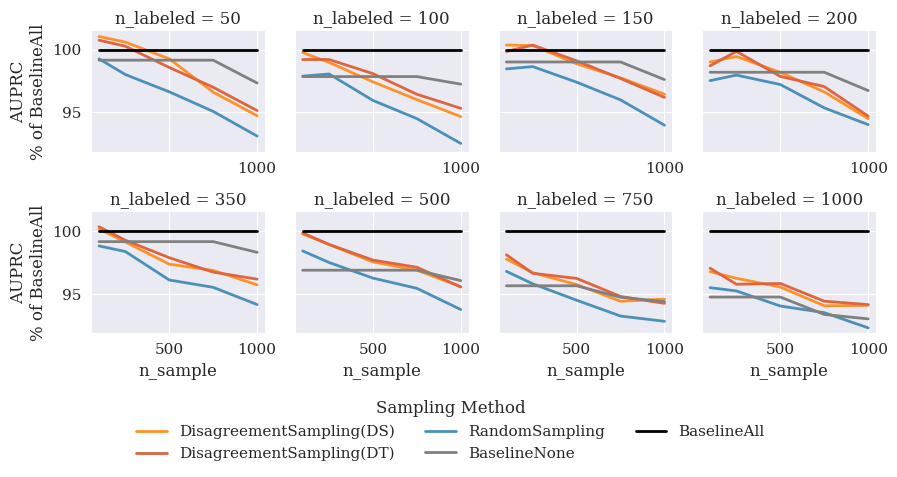

In [23]:
# Start from the best_performance_per_bracket DataFrame
df_plot = best_performance_per_bracket.copy()
df_plot['% of BaselineAll'] = 100 * df_plot['value'] / df_plot['baseline_all']
df_plot['sampling_method'] = df_plot['sampling_method'].astype(str)

# BaselineNone line
df_none = df_plot[['n_sample', 'n_labeled', 'baseline_none', 'baseline_all']].copy()
df_none['% of BaselineAll'] = 100 * df_none['baseline_none'] / df_none['baseline_all']
df_none['sampling_method'] = 'BaselineNone'
df_none = df_none[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']]

# BaselineAll line
df_all = df_plot[['n_sample', 'n_labeled']].drop_duplicates().copy()
df_all['% of BaselineAll'] = 100
df_all['sampling_method'] = 'BaselineAll'
df_all = df_all[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']]

# # BaselineRawFeatures line
# df_raw = best_performance_per_bracket[['n_sample', 'n_labeled', 'baseline_raw_features', 'baseline_all']].copy()
# df_raw['% of BaselineAll'] = 100 * df_raw['baseline_raw_features'] / df_raw['baseline_all']
# df_raw['sampling_method'] = 'BaselineRawFeatures'
# df_raw = df_raw[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']]

# Concatenate all lines
df_plot = pd.concat([
    df_plot[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']],
    df_none,
    df_all,
    # df_raw
], ignore_index=True)

color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    # 'BaselineRawFeatures': '#9467bd',  # purple
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}

# Plot
g = sns.relplot(
    data=df_plot,
    x='n_sample',
    y='% of BaselineAll',
    hue='sampling_method',
    col='n_labeled',
    kind='line',
    palette=color_dict,
    facet_kws={'sharey': True, 'sharex': True},
    col_wrap=4,
    errorbar=None,
    height=2, aspect=0.8,
)

g.set_axis_labels('n_sample', 'AUPRC\n% of BaselineAll')

# Force legend creation if missing
g._legend.remove()
g._legend = g.fig.legend(
    handles=g._legend_data.values(),
    labels=g._legend_data.keys(),
    title='Sampling Method',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    frameon=False
)

plt.subplots_adjust(bottom=0.25)  # Adjust space to make room
plt.tight_layout()
plt.savefig('plots/1_2_nsample_split_by_nlabeled_embedding_space.pdf', bbox_inches='tight')
plt.show()



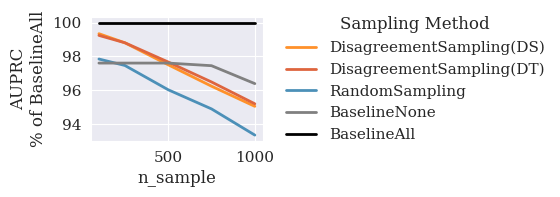

In [24]:
fig, ax = plt.subplots(figsize=(6, 2))  # Set width and height in inches

g = sns.lineplot(
    data=df_plot,
    x='n_sample',
    y='% of BaselineAll',
    hue='sampling_method',
    palette=color_dict,
    errorbar=None,
    ax=ax
)

ax.set_xlabel('n_sample')
ax.set_ylabel('AUPRC\n% of BaselineAll')

# Move legend to the right outside the plot
legend = ax.legend(
    title='Sampling Method',
    bbox_to_anchor=(1.1, 0.5),
    loc='center left',
    borderaxespad=0,
    frameon=False
)

plt.tight_layout()
plt.savefig('plots/1_2_nsample_embedding_space.pdf', bbox_inches='tight')
plt.show()

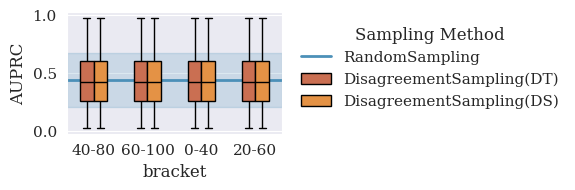

In [17]:
# Filter for the metric of interest
df_plot = linear_performance_pivot[linear_performance_pivot['metric'] == 'auprc_macro_test']

# Calculate mean and std for RandomSampling
rand_vals = df_plot[df_plot['sampling_method'] == 'RandomSampling']['value']
rand_mean = rand_vals.mean()
rand_std = rand_vals.std()

plt.figure(figsize=(6, 2))
ax = plt.gca()

# Add horizontal band for RandomSampling
ax.axhline(rand_mean, color=color_dict['RandomSampling'], linestyle='-', label='RandomSampling')
ax.fill_between(
    x=[-0.5, len(df_plot['bracket'].unique()) - 1.5],
    y1=rand_mean - rand_std,
    y2=rand_mean + rand_std,
    color=color_dict['RandomSampling'],
    alpha=0.2
)

# Boxplot for other sampling methods
sns.boxplot(
    data=df_plot[df_plot['sampling_method'] != 'RandomSampling'],
    x="bracket",
    y="value",
    hue="sampling_method",
    palette=color_dict,
    width=0.5,
    ax=ax
)

plt.ylabel('AUPRC')

# Fix legend: combine axhline and boxplot handles
handles, labels = ax.get_legend_handles_labels()
# Remove duplicate labels (if any)
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title='Sampling Method', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.savefig('plots/1_3_brackets_embedding.pdf', bbox_inches='tight')
plt.show()

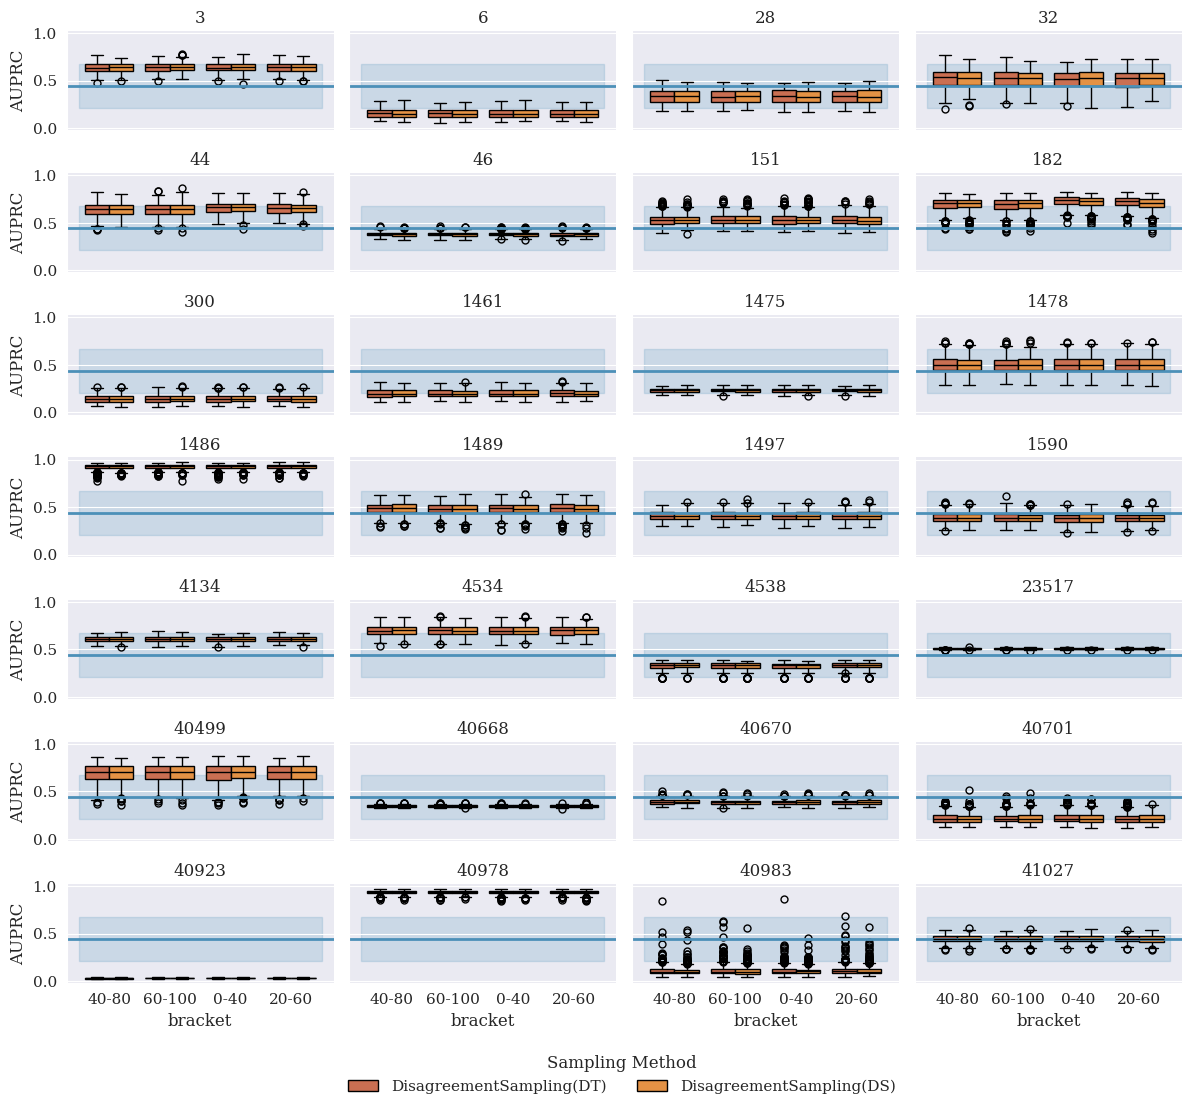

In [18]:
# Filter relevant data
df_plot = linear_performance_pivot[linear_performance_pivot['metric'] == 'auprc_macro_test']
rand_vals = df_plot[df_plot['sampling_method'] == 'RandomSampling']['value']
rand_mean = rand_vals.mean()
rand_std = rand_vals.std()

# Exclude RandomSampling from the boxplot data
df_no_rand = df_plot[df_plot['sampling_method'] != 'RandomSampling']

# Create faceted boxplots by dataset
g = sns.catplot(
    data=df_no_rand,
    x="bracket",
    y="value",
    hue="sampling_method",
    col="dataset",
    col_wrap=4,
    kind="box",
    palette=color_dict,
    height=1.5,
    aspect=2,
    sharey=True
)

# Add horizontal line and band to each subplot
for ax in g.axes.flat:
    ax.axhline(rand_mean, color=color_dict['RandomSampling'], linestyle='-')
    ax.fill_between(
        x=[-0.5, len(df_plot['bracket'].unique()) - 1.5],
        y1=rand_mean - rand_std,
        y2=rand_mean + rand_std,
        color=color_dict['RandomSampling'],
        alpha=0.2,
        zorder=0
    )

g.set_titles(col_template="{col_name}")
g.set_axis_labels("bracket", "AUPRC")

g._legend.remove()
g.fig.legend(
    handles=g._legend_data.values(),
    labels=g._legend_data.keys(),
    title="Sampling Method",
    loc="lower center",
    bbox_to_anchor=(0.425, -0.06),
    ncol=3,
    frameon=False
)

plt.savefig('plots/1_3_brackets_split_by_dataset_embedding.pdf', bbox_inches='tight')
plt.show()